In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy




In [2]:
CLASS = 7
batch_size = 64
img_height = 64
img_width = 64
train_dir = os.path.join("dataset/train/")
test_dir = os.path.join("dataset/test")
CLASS, batch_size, (img_height, img_width), train_dir, test_dir

(7, 64, (64, 64), 'dataset/train/', 'dataset/test')

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
#     color_mode="grayscale",
    label_mode="categorical",
    interpolation="area",
    validation_split=0.01,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
train_ds, train_ds.class_names

Found 28709 files belonging to 7 classes.
Using 28422 files for training.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

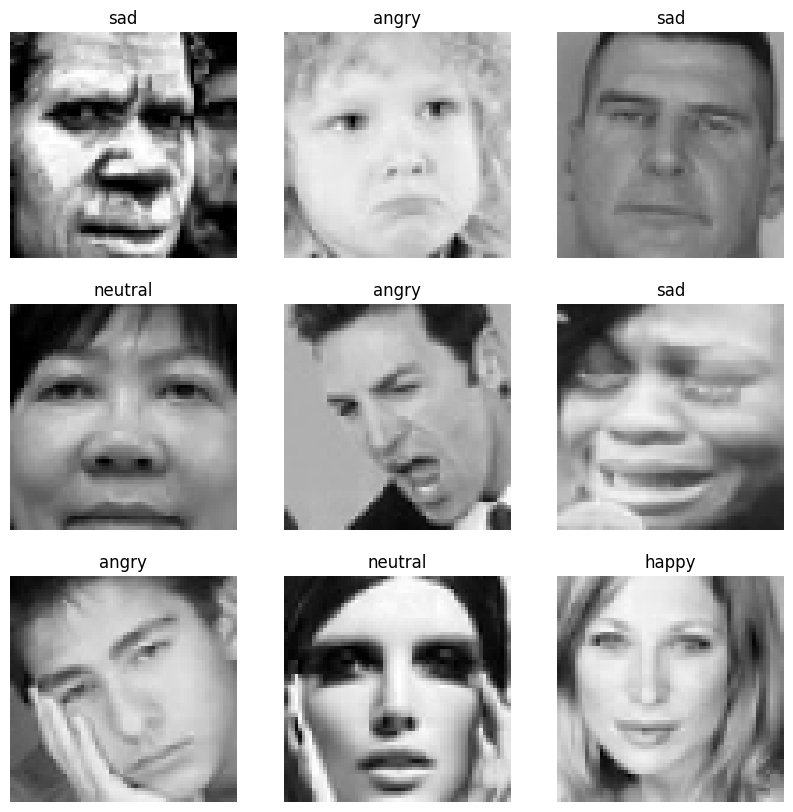

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
#     plt.title(train_ds.class_names[labels[i]])
    plt.title(train_ds.class_names[np.argmax(labels[i])])
#     print(np.argmax(labels[i]))
    plt.axis("off")

In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
#     color_mode="grayscale",
    label_mode="categorical",
    interpolation="area",
    validation_split=0.99,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
test_ds, test_ds.class_names

Found 7178 files belonging to 7 classes.
Using 7106 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
#     color_mode="grayscale",
    label_mode="categorical",
    interpolation="area",
    validation_split=0.99,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
test_ds, test_ds.class_names

Found 7178 files belonging to 7 classes.
Using 7106 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [7]:
from keras.layers import Dense, Conv2D, Flatten,ReLU , MaxPooling2D, Rescaling, Reshape, Dropout, BatchNormalization, AveragePooling2D, Input, Concatenate
from tensorflow.keras.layers import LayerNormalization

# resnet50

def residual_block(x, filters, strides=1):
    # Shortcut branch
    shortcut = x

    # Main branch
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut branch if strides are different
    if strides != 1 or filters != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = ReLU()(x)
    return x

inputs = Input(shape=(img_height, img_width, 3))  # Define the input layer
x = inputs  # Assign the input to x
x = Rescaling(1./255) (x)

# Initial conv layers (modified for smaller input)
x = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)  # Reduced kernel size and filters
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

# Stack residual blocks (adjust filter counts as needed)
x = residual_block(x, filters=32, strides=1)
x = residual_block(x, filters=32, strides=1)
x = residual_block(x, filters=64, strides=2)
x = residual_block(x, filters=64, strides=1)
x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128, strides=1)
x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256, strides=1)

# Final layers
x = layers.GlobalAveragePooling2D()(x)

outputs = Dense(CLASS, activation='softmax')(x)  # Adjust output neurons for your task

model = models.Model(inputs=inputs, outputs=outputs)  # Create the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        280 │ rescaling[0][0]   │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │         40 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,912 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        352 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]  

 Total params: 2,797,479 (10.67 MB)

 Trainable params: 2,792,659 (10.65 MB)

 Non-trainable params: 4,820 (18.83 KB)

In [8]:
epochs=25
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=epochs/10, min_delta=0.001, mode='max', restore_best_weights=True)]
)

Epoch 1/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 140s 296ms/step - accuracy: 0.3548 - loss: 1.6893 - precision: 0.5879 - recall: 0.1341 - val_accuracy: 0.2458 - val_loss: 2.1364 - val_precision: 0.2580 - val_recall: 0.2150
Epoch 2/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 107s 241ms/step - accuracy: 0.4991 - loss: 1.2981 - precision: 0.7246 - recall: 0.2964 - val_accuracy: 0.4848 - val_loss: 1.3831 - val_precision: 0.6472 - val_recall: 0.3142
Epoch 3/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 127s 285ms/step - accuracy: 0.5537 - loss: 1.1707 - precision: 0.7260 - recall: 0.3703 - val_accuracy: 0.4602 - val_loss: 1.5157 - val_precision: 0.5874 - val_recall: 0.3259
Epoch 4/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 110s 247ms/step - accuracy: 0.6042 - loss: 1.0501 - precision: 0.7500 - recall: 0.4537 - val_accuracy: 0.4814 - val_loss: 1.4448 - val_precision: 0.5940 - val_recall: 0.3673
Epoch 5/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 106s 239ms/step - accuracy: 0.6568 - loss: 0.9211 - precision: 0.7690 - recall: 0.5298 - val_accuracy: 0

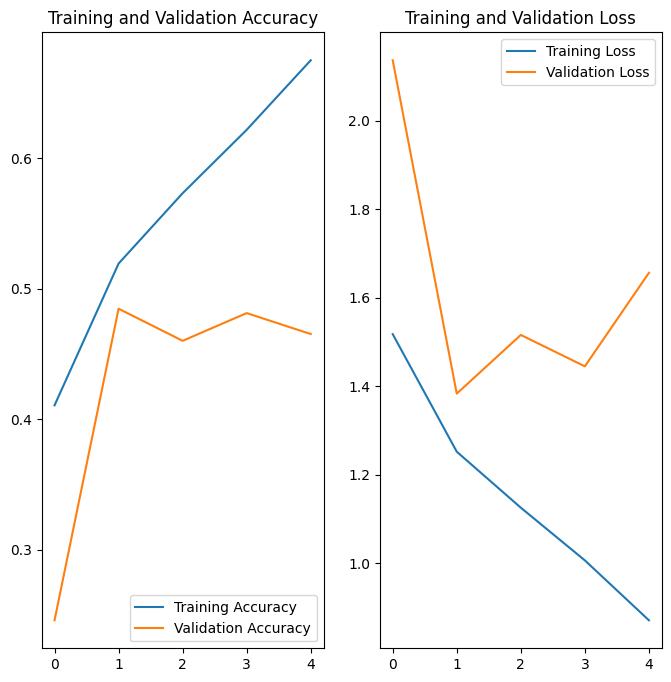

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(val_acc))  # Or len(val_loss), or any validation metric


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix

# Get the predictions for the test dataset
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test dataset
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step
Confusion Matrix:
[[ 97   4  10 353 309 123  55]
 [ 11   0   1  41  24  23   9]
 [ 99   5  12 368 305 159  63]
 [173  16  22 659 537 242 110]
 [137   3  17 449 353 188  71]
 [114  12  21 493 349 172  74]
 [ 83   3   8 331 224 111  63]]


In [ ]:
model.save('model.h5')